In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [37]:
import surprise
import implicit
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import PredefinedKFold
import scipy.sparse as sp
from sklearn.decomposition import NMF

Dataset original de https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews

In [ ]:
animes = pd.read_csv("data/animes.csv")
animes.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [ ]:
profiles = pd.read_csv("data/profiles.csv")
profiles.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In [ ]:
reviews = pd.read_csv("data/reviews.csv")

# Assign a unique id to each username
unique_users = reviews["username"].unique()
user_mapping = {user: i for i, user in enumerate(unique_users)}
reviews["user_id"] = reviews["username"].map(user_mapping)

# Assign anime uid from animes df (join on reviews.anime = animes.title)
anime_ids = animes[['title', 'uid']].copy()
reviews = pd.merge(reviews, anime_ids,
                   left_on='anime',
                   right_on='title',
                   how='left')
reviews = reviews.drop(columns=['title'])
reviews = reviews.rename(columns={'uid': 'item_id', 'score': 'rating'})

reviews.head()

,username,anime,rating,text,user_id,item_id
0,baekbeans,Juuni Taisen,7,While people may prize the unpredictability of...,0,35076.0
1,baekbeans,No Game No Life: Zero,8,If you watch no game no life zero with high ex...,0,33674.0
2,baekbeans,No Game No Life: Zero,8,If you watch no game no life zero with high ex...,0,33674.0
3,baekbeans,Made in Abyss,10,Let me start off by saying that Made in Abyss ...,0,34599.0
4,baekbeans,Made in Abyss,10,Let me start off by saying that Made in Abyss ...,0,34599.0


# Análisis de datos

Quitar nacimiento que no tiene año

In [47]:
profiles["birthday_year"] = profiles["birthday"].apply(lambda x: x[-4:] if pd.notna(x) else None)
profiles = profiles[profiles["birthday_year"].apply(lambda x: len(x) == 4 and x.isdigit() if pd.notna(x) else True)]
print(profiles["birthday_year"].value_counts())

birthday_year
1997    3405
1996    3317
1995    3294
1994    3140
1998    2899
        ... 
2021       2
1946       2
1951       2
1941       1
1953       1
Name: count, Length: 89, dtype: int64


In [73]:
reviews_with_more_than_one = reviews.groupby("user_id").filter(lambda x: len(x) > 1)
reviews_with_more_than_one.head()
train_file, validation_file = train_test_split(reviews_with_more_than_one, test_size=0.2, random_state=42)
validation_file = validation_file[validation_file["user_id"].isin(train_file["user_id"])] # Ensure all users in validation are also in train

In [49]:
def get_stats(df):
    users_quantity = df["user_id"].nunique()
    items_quantity = df["item_id"].nunique()

    total_ratings = len(df)
    avg_ratings_per_user = total_ratings / users_quantity
    avg_ratings_per_item = total_ratings / items_quantity

    avg_rating = df["rating"].mean()
    std_rating = df["rating"].std()
    highest_number_of_ratings_by_user = df.groupby("user_id").size().max()
    highest_number_of_ratings_for_item = df.groupby("item_id").size().max()

    density = (total_ratings / (users_quantity * items_quantity)) * 100

    return {
        "Número de usuarios": users_quantity,
        "Número de animes": items_quantity,
        "Total de ratings": total_ratings,
        "Media de ratings por usuario": avg_ratings_per_user,
        "Media de ratings por anime": avg_ratings_per_item,
        "Rating media": avg_rating,
        "Desviación estándar de ratings": std_rating,
        "Mayor número de ratings por un usuario": highest_number_of_ratings_by_user,
        "Mayor número de ratings para un anime": highest_number_of_ratings_for_item,
        "Densidad (%)": f"{density}%"
    }

train_stats = get_stats(train_file)
val_stats = get_stats(validation_file)

rows = []
for key in train_stats.keys():
    rows.append([key, train_stats[key], val_stats[key]])

print(tabulate(rows, headers=["Estadística", "Training", "Validation"], tablefmt="grid"))


+----------------------------------------+----------------------+-----------------------+
| Estadística                            | Training             | Validation            |
+========================================+======================+=======================+
| Número de usuarios                     | 28397                | 15582                 |
+----------------------------------------+----------------------+-----------------------+
| Número de animes                       | 7200                 | 4457                  |
+----------------------------------------+----------------------+-----------------------+
| Total de ratings                       | 150920               | 36641                 |
+----------------------------------------+----------------------+-----------------------+
| Media de ratings por usuario           | 5.3146459133007005   | 2.351495315107175     |
+----------------------------------------+----------------------+-----------------------+
| Media de

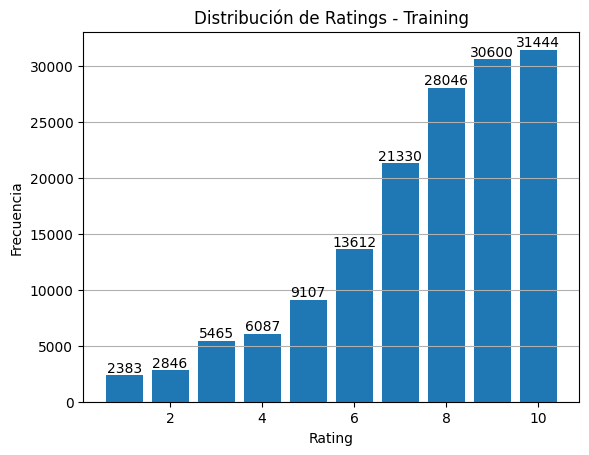

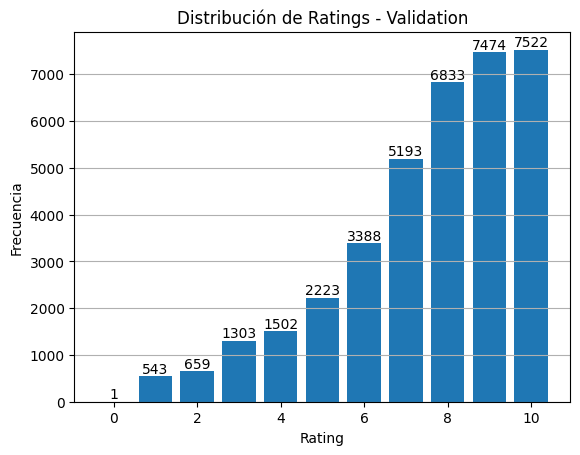

In [50]:
def plot_rating_distribution(ratings, title):
    counts = ratings.value_counts()
    bars = plt.bar(counts.index, counts.values)
    for bar, count in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 str(count), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel("Rating")
    plt.ylabel("Frecuencia")
    plt.grid(axis='y')
    plt.show()

plot_rating_distribution(train_file["rating"], "Distribución de Ratings - Training")
plot_rating_distribution(validation_file["rating"], "Distribución de Ratings - Validation")

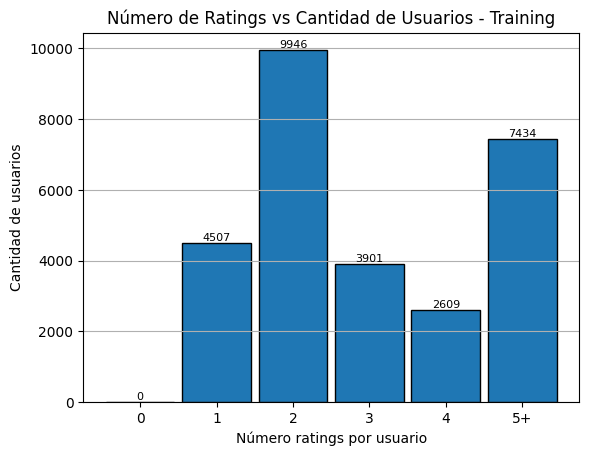

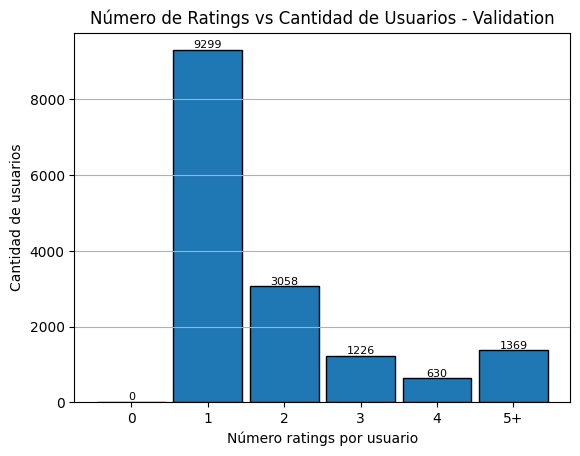

In [51]:
MAX_RATINGS = 5

def plot_ratings_per_user_distribution(df, title):
    ratings_per_user = df.groupby("user_id").size()
    clipped = ratings_per_user.clip(upper=MAX_RATINGS)
    counts = clipped.value_counts().reindex(range(0, MAX_RATINGS+1), fill_value=0)
    counts.index = [str(i) if i < MAX_RATINGS else f"{MAX_RATINGS}+" for i in range(0, MAX_RATINGS+1)]

    bars = plt.bar(counts.index, counts.values, width=0.9, edgecolor="black")
    for bar, count in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 str(count), ha="center", va="bottom", fontsize=8)

    plt.title(title)
    plt.xlabel("Número ratings por usuario")
    plt.ylabel("Cantidad de usuarios")
    plt.grid(axis="y")
    plt.show()


plot_ratings_per_user_distribution(train_file, "Número de Ratings vs Cantidad de Usuarios - Training")
plot_ratings_per_user_distribution(validation_file, "Número de Ratings vs Cantidad de Usuarios - Validation")


### Analísis de genero y edad

In [52]:
profiles["gender"].value_counts()

gender
Male          33418
Female        13279
Non-Binary      636
Name: count, dtype: int64

In [53]:
profiles["birthday_year"] = profiles["birthday_year"].apply(lambda x: int(x) if pd.notna(x) else None)
profiles["edad"] = profiles["birthday_year"].apply(lambda x: 2025 - x if pd.notna(x) else None)
profiles["edad"].value_counts().sort_index()

edad
4.0       2
5.0      41
6.0      20
7.0      29
8.0      17
       ... 
91.0      2
92.0      7
93.0      9
94.0     11
95.0    278
Name: count, Length: 89, dtype: int64

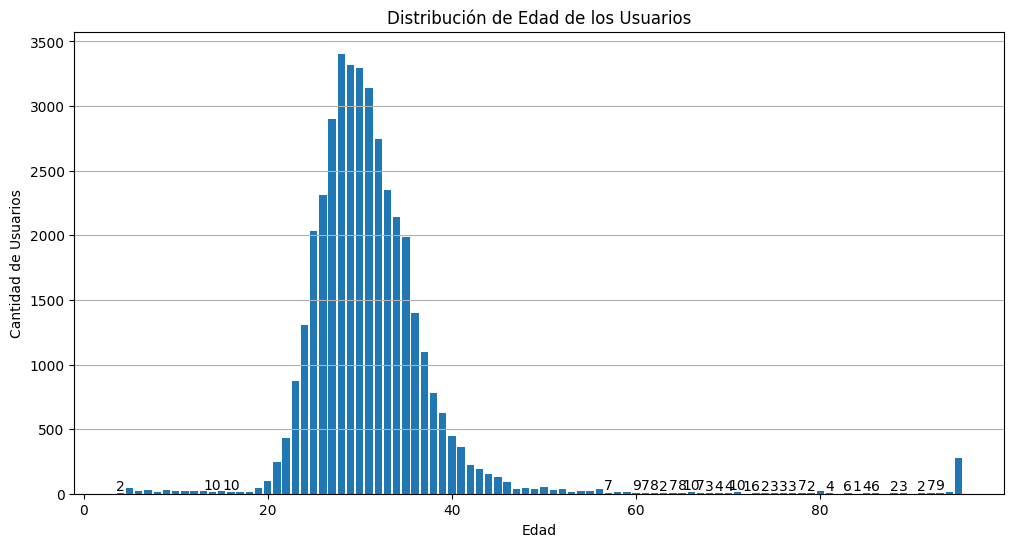

In [54]:
age_counts = profiles["edad"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(age_counts.index, age_counts.values)
plt.xlabel("Edad")
plt.ylabel("Cantidad de Usuarios")
plt.title("Distribución de Edad de los Usuarios")
plt.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    if height <= 10:
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 '%d' % int(height),
                 ha='center', va='bottom')

plt.show()

# Listas de Recomendaciones

In [74]:
train_file[['user_id', 'item_id', 'rating']].to_csv("train", index=False, header=False)
validation_file[['user_id', 'item_id', 'rating']].to_csv("test", index=False, header=False)

In [56]:
reader = surprise.Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
data = surprise.Dataset.load_from_folds([('train', 'test')], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

In [57]:
df_train = pd.read_csv(
    "train", sep=",", names=["userid", "itemid", "rating"], header=None
)

df_train.rating = [1 if x >= 5 else 0 for x in df_train.rating]

df_train.head()

,userid,itemid,rating
0,2052,12445.0,1
1,5141,34599.0,1
2,3340,37510.0,1
3,588,853.0,1
4,4822,27775.0,1


In [58]:
df_test = pd.read_csv(
    "test", sep=",", names=["userid", "itemid", "rating"], header=None
)

df_test.rating = [1 if x >= 5 else 0 for x in df_test.rating]

df_test.head()

,userid,itemid,rating
0,18887,37450.0,1
1,8831,32379.0,0
2,37283,36882.0,1
3,35602,10490.0,1
4,39042,NaN,1


In [59]:
user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [60]:
item_interaction_counts = df_train['itemid'].value_counts()
user_count = df_train['userid'].nunique()
item_popularity = (item_interaction_counts / user_count).to_dict()

In [61]:
metadata = animes[['uid', 'genre']]
item_categories: dict[int, set[str | None]] = {}
for row in metadata.itertuples():
    item_categories[int(row[1]) if row[1].is_integer() else row[1]] = set(map(lambda i: i.strip(), row[2].split(','))) if isinstance(row[2], str) else set()

def precision_at_k(r, k):
  assert 1 <= k <= r.size
  return (np.asarray(r)[:k]).mean()


def average_precision_at_k(r, k):
    r = np.asarray(r)
    n_rel = r.sum()
    if n_rel == 0:
        return 0.0
    vectorized_precision = np.vectorize(lambda i: precision_at_k(r, i))
    indices = np.arange(1, len(r) + 1)
    precisions = vectorized_precision(
        indices
    )
    score = np.sum(precisions * r)
    return score / min(k, n_rel)


def recall_at_k(r, k):
    r = np.asarray(r)
    n_rel = r.sum()
    if n_rel == 0:
        return 0.0
    return np.sum(r[:k]) / n_rel


def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    if r.size:
        return np.sum(
            np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2))
        )
    return 0.0


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.0
    return dcg_at_k(r, k) / idcg


def novelty(recommended_items):
    score = 0
    for item in recommended_items:
        popularity = item_popularity.get(item, 0)
        score += np.log2(1/popularity) if popularity > 0 else 0
    return score / len(recommended_items) if any(recommended_items) else 0


def diversity(r, k):
    score = 0
    for i in range(len(r)):
        for j in range(i + 1, len(r)):
            item_i = r[i]
            item_j = r[j]
            categories_i = item_categories.get(item_i, set())
            categories_j = item_categories.get(item_j, set())
            if categories_i or categories_j:
                intersection = categories_i.intersection(categories_j)
                union = categories_i.union(categories_j)
                jaccard_distance = 1 - (len(intersection) / len(union))
                score += jaccard_distance

    num_pairs = (k * (k - 1)) / 2
    return score / num_pairs if num_pairs > 0 else 0

In [62]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sp.csr_matrix(sparse_matrix.T)

user_item_matrix = matrix.T.tocsr()

In [63]:
user2row = {user_id: matrix_row for matrix_row, user_id in enumerate(user_items.keys())}
row2user = {matrix_row: user_id for user_id, matrix_row in user2row.items()}

item2col = {item_id: matrix_col for matrix_col, item_id in enumerate(itemset)}
col2item = {matrix_col: item_id for item_id, matrix_col in item2col.items()}

In [64]:
animes['popularity_score'] = (
                (1 / animes['popularity']) * 0.4 +
                (1 / animes['ranked'].fillna(10000)) * 0.3 +
                animes['score'] * 0.3
            )
popular_animes = animes.sort_values('popularity_score', ascending=False)

In [65]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        # if model == "most_popular":
        #     self.most_popular = AnimeMostPopularRecommender(popularity_metric="weighted")
        #     self.most_popular.fit(animes)

    def recommend(self, user_id, user_item_matrix, n=10):
        if self.model == "random":
            seen = set(user_items.get(user_id, []))
            item_array = np.array(list(itemset))
            mask = ~np.isin(item_array, list(seen))
            candidates = item_array[mask]
            return np.random.choice(candidates, size=n, replace=False)

        if self.model == "most_popular":
            seen = set(user_items.get(user_id, []))
            recommendations = []
            for _, anime in popular_animes.iterrows():
                if anime['uid'] not in seen:
                    recommendations.append(anime['uid'])
                if len(recommendations) >= n:
                    break
            return recommendations

        if hasattr(self.model, 'recommend') and callable(getattr(self.model, 'recommend')):
            try:
                user_row = user2row[user_id]
                rec = self.model.recommend(user_row, user_item_matrix[user_row], n)[0]
                return np.array([col2item[col] for col in rec])
            except KeyError:
                # Fallback a Most Popular
                # print(f"User {user_id} not in user2row, using most popular fallback")
                seen = set(user_items.get(user_id, []))
                recommendations = []
                for _, anime in popular_animes.iterrows():
                    if anime['uid'] not in seen:
                        recommendations.append(anime['uid'])
                    if len(recommendations) >= n:
                        break
                return recommendations

        else:
            trainset = self.model.trainset
            u = trainset.to_inner_uid(str(user_id))

            pu = self.model.pu[u]
            bu = self.model.bu[u]
            qi = self.model.qi
            bi = self.model.bi
            mu = trainset.global_mean

            scores = mu + bu + bi + qi @ pu

            known_items = set([j for (j, _) in trainset.ur[u]])
            scores[list(known_items)] = -np.inf

            top_n_idx = np.argpartition(scores, -n)[-n:]
            top_n_idx = top_n_idx[np.argsort(scores[top_n_idx])[::-1]]

            return np.array([int(trainset.to_raw_iid(i)) for i in top_n_idx])

In [66]:
def evaluate_model(model, n):
    mean_recall = 0.0
    mean_ap = 0.0
    mean_ndcg = 0.0
    mean_novelty = 0.0
    mean_diversity = 0.0
    for user_id in user_items_test.keys():
        rec = ModelWrapper(model).recommend(user_id, user_item_matrix, n)
        rel_vector = np.isin(rec, user_items_test[user_id], assume_unique=True).astype(int)
        mean_recall += recall_at_k(rel_vector, n)
        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n)
        mean_novelty += novelty(rec)
        mean_diversity += diversity(rec, n)

    mean_recall /= len(user_items_test)
    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_novelty /= len(user_items_test)
    mean_diversity /= len(user_items_test)

    return mean_recall, mean_ap, mean_ndcg, mean_novelty, mean_diversity

In [75]:
def plot_results(results, xlabel, title):
    df = pd.DataFrame(results, columns=["K", "Recall", "MAP", "nDCG", "Novelty", "Diversity"])

    max_info = np.log2(len(itemset))
    df["Novelty (norm)"] = (df["Novelty"] / max_info)

    plt.figure(figsize=(6,4))
    for metric in ["Recall", "MAP", "nDCG"]:
        plt.plot(df["K"], df[metric], marker="o", label=metric)

    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid()

    plt.figure(figsize=(6,4))
    for metric in ["Novelty (norm)", "Diversity"]:
        plt.plot(df["K"], df[metric], marker="o", label=metric)

    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

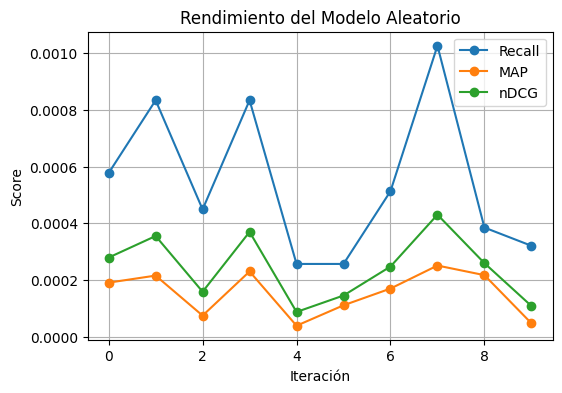

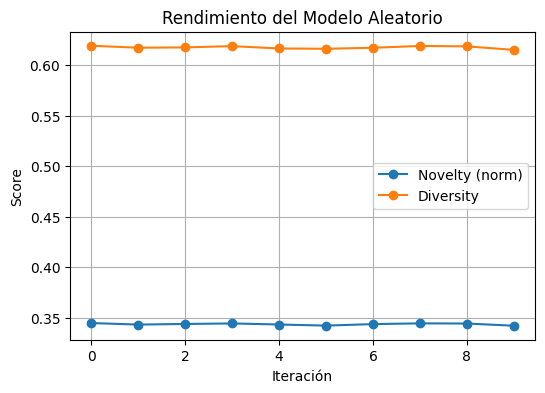

In [76]:
results_rnd = []

for i in range(10):
    model_rnd = "random"
    recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd = evaluate_model(model_rnd, 10)
    results_rnd.append([i, recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd])

plot_results(results_rnd, "Iteración", "Rendimiento del Modelo Aleatorio")

In [ ]:
results_mp = []

# for i in range(10):
model_mp = "most_popular"
recall_mp, map_mp, mndcg_mp, novelty_mp, diversity_mp = evaluate_model(model_mp, 10)
results_mp.append([i, recall_mp, map_mp, mndcg_mp, novelty_mp, diversity_mp])

# plot_results(results_mp, "Iteración", "Rendimiento del Modelo MostPopular")
print(f"Recall: {recall_mp}")
print(f"MAP: {map_mp}")
print(f"nDCG: {mndcg_mp}")
print(f"Novelty: {novelty_mp}")
print(f"Diversity: {diversity_mp}")

# De aqui para abajo no funciona xd

50


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0010020732879638672 seconds
  warnings.warn(


100


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


150
200
250
300
350
400
450
500


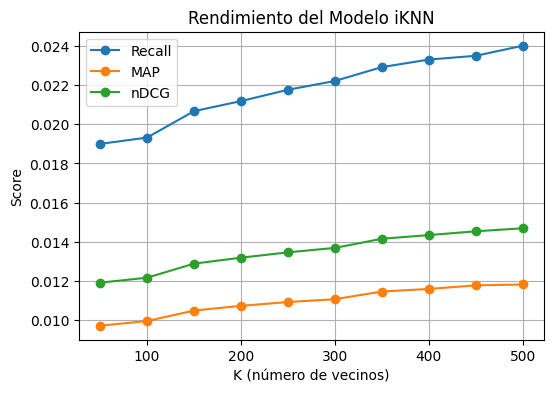

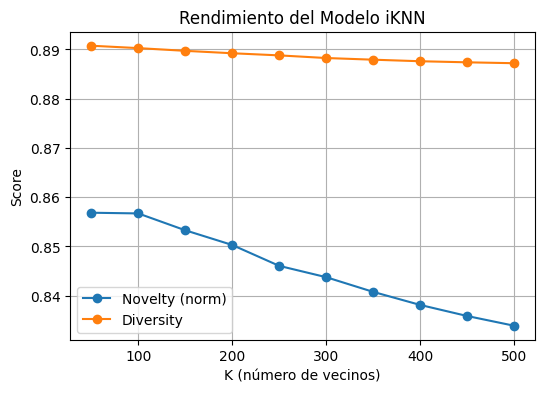

In [68]:
k_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
results_iknn = []

for k in k_values:
    print(k)
    model_iknn = implicit.nearest_neighbours.CosineRecommender(K=k)
    model_iknn.fit(user_item_matrix, show_progress=False)
    recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn = evaluate_model(model_iknn, 10)
    results_iknn.append([k, recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn])

plot_results(results_iknn, "K (número de vecinos)", "Rendimiento del Modelo iKNN")

In [69]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_svd = []

for f in factor_values:
    model_svd = SVD(n_factors=f)
    model_svd.fit(trainset)
    recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd = evaluate_model(model_svd, 10)
    results_svd.append([f, recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd])

plot_results(results_svd, "Número de factores latentes", "Rendimiento del Modelo FunkSVD")

ValueError: invalid literal for int() with base 10: '4181.0'

c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


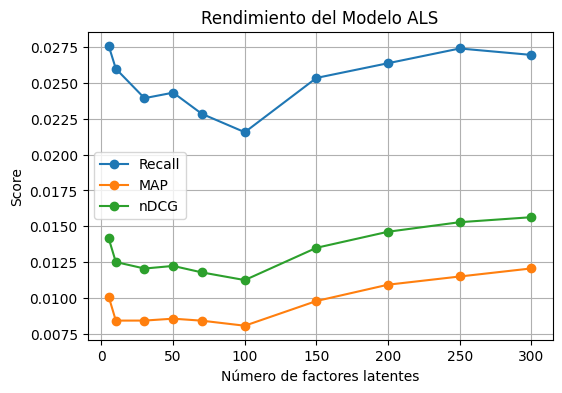

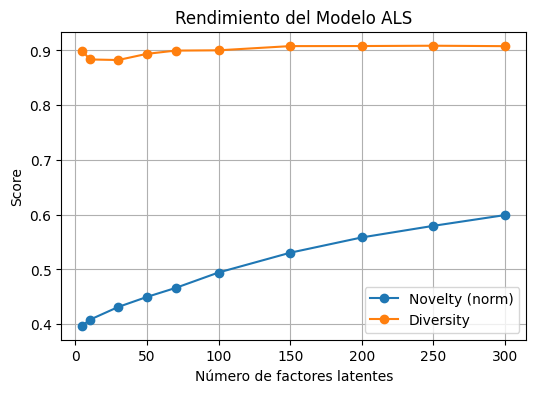

In [70]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_als = []

for f in factor_values:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als.fit(user_item_matrix, show_progress=False)
    recall_als, map_als, mndcg_als, novelty_als, diversity_als = evaluate_model(model_als, 10)
    results_als.append([f, recall_als, map_als, mndcg_als, novelty_als, diversity_als])

plot_results(results_als, "Número de factores latentes", "Rendimiento del Modelo ALS")

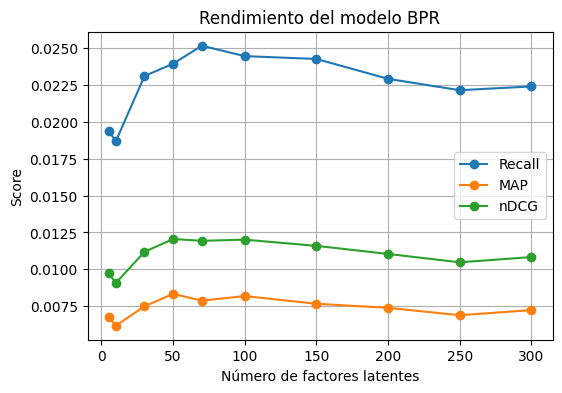

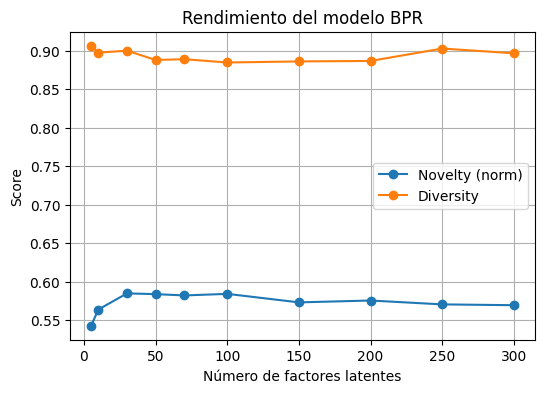

In [71]:
factor_values = [5, 10, 30, 50, 70, 100, 150, 200, 250, 300]
results_bpr = []

for f in factor_values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
    model_bpr.fit(user_item_matrix, show_progress=False)
    recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr = evaluate_model(model_bpr, 10)
    results_bpr.append([f, recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr])

plot_results(results_bpr, "Número de factores latentes", "Rendimiento del modelo BPR")

In [ ]:
def best_performing_by_rank_metrics(results):
    best_model = max(results, key=lambda x: x[1] * 0.2 + x[2] * 0.4 + x[3] * 0.4)
    return best_model

def best_performing_by_novelty_diversity(results):
    best_model = max(results, key=lambda x: (x[4] / np.log2(len(itemset))) * 0.5 + x[5] * 0.5)
    return best_model

In [ ]:
i, recall_rnd, map_rnd, ndcg_rnd, novelty_rnd, diversity_rnd = best_performing_by_rank_metrics(results_rnd)
k, recall_iknn, map_iknn, ndcg_iknn, novelty_iknn, diversity_iknn = best_performing_by_rank_metrics(results_iknn)
f_svd, recall_svd, map_svd, ndcg_svd, novelty_svd, diversity_svd = best_performing_by_rank_metrics(results_svd)
f_als, recall_als, map_als, ndcg_als, novelty_als, diversity_als = best_performing_by_rank_metrics(results_als)
f_bpr, recall_bpr, map_bpr, ndcg_bpr, novelty_bpr, diversity_bpr = best_performing_by_rank_metrics(results_bpr)

In [ ]:
rows = [
    [f"RANDOM ({i})", recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd],
    [f"iKNN ({k})", recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn],
    [f"SVD ({f_svd})", recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd],
    [f"ALS ({f_als})", recall_als, map_als, mndcg_als, novelty_als, diversity_als],
    [f"BPR ({f_bpr})", recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr],
]
print(tabulate(rows, headers=["Modelo", "RECALL", "MAP", "MNDCG", "NOVELTY", "DIVERSITY"], tablefmt="grid"))

In [ ]:
i, recall_rnd, map_rnd, ndcg_rnd, novelty_rnd, diversity_rnd = best_performing_by_novelty_diversity(results_rnd)
k, recall_iknn, map_iknn, ndcg_iknn, novelty_iknn, diversity_iknn = best_performing_by_novelty_diversity(results_iknn)
f_svd, recall_svd, map_svd, ndcg_svd, novelty_svd, diversity_svd = best_performing_by_novelty_diversity(results_svd)
f_als, recall_als, map_als, ndcg_als, novelty_als, diversity_als = best_performing_by_novelty_diversity(results_als)
f_bpr, recall_bpr, map_bpr, ndcg_bpr, novelty_bpr, diversity_bpr = best_performing_by_novelty_diversity(results_bpr)

In [ ]:
rows = [
    [f"RANDOM ({i})", recall_rnd, map_rnd, mndcg_rnd, novelty_rnd, diversity_rnd],
    [f"iKNN ({k})", recall_iknn, map_iknn, mndcg_iknn, novelty_iknn, diversity_iknn],
    [f"SVD ({f_svd})", recall_svd, map_svd, mndcg_svd, novelty_svd, diversity_svd],
    [f"ALS ({f_als})", recall_als, map_als, mndcg_als, novelty_als, diversity_als],
    [f"BPR ({f_bpr})", recall_bpr, map_bpr, mndcg_bpr, novelty_bpr, diversity_bpr],
]
print(tabulate(rows, headers=["Modelo", "RECALL", "MAP", "MNDCG", "NOVELTY", "DIVERSITY"], tablefmt="grid"))

In [ ]:
# --- INICIO: Nuevo código para Modelo y Evaluación ---

if train_file.empty or validation_file.empty:
    print("Datos de entrenamiento o validación vacíos. No se puede entrenar el modelo.")
else:
    print("Iniciando entrenamiento y evaluación del modelo de recomendación...")

    # Definir item_popularity (necesario para la métrica 'novelty')
    # Se calcula sobre el set de entrenamiento
    item_popularity = train_file['item_id'].value_counts(normalize=True).to_dict()

    # 1. Preparar datos para Factorización de Matriz
    # Mapear user_id y item_id a índices de matriz (enteros de 0 a N-1)
    users = sorted(train_file['user_id'].unique())
    items = sorted(train_file['item_id'].unique())

    user_mapper = {user: i for i, user in enumerate(users)}
    item_mapper = {item: i for i, item in enumerate(items)}

    # Mapeo inverso para traducir índices de vuelta a item_id
    item_inv_mapper = {i: item for item, i in item_mapper.items()}

    # Mapear los dataframes a los nuevos índices
    rows = train_file['user_id'].map(user_mapper)
    cols = train_file['item_id'].map(item_mapper)
    ratings = train_file['rating']

    # Crear la matriz dispersa (sparse matrix) de interacciones
    R_train = matrix
    print(f"Creada matriz usuario-item de dimensiones: {R_train.shape}")

    # 2. Entrenar el modelo NMF
    N_FACTORS = 50  # Número de factores latentes (hiperparámetro)
    K = 10          # Top-K para las métricas

    model = NMF(
        n_components=N_FACTORS,
        init='random',
        random_state=42,
        max_iter=200,  # 200 iteraciones es común, 500 es más robusto
        solver='cd',   # 'cd' (Coordinate Descent) es más rápido para datos dispersos
        tol=1e-4
    )

    print(f"Entrenando modelo NMF con {N_FACTORS} factores...")
    W = model.fit_transform(R_train)  # Matriz de factores de Usuario (Users x Factors)
    H = model.components_           # Matriz de factores de Item (Factors x Items)
    print("Entrenamiento completado.")

    # 3. Obtener la matriz de predicciones completas
    # R_hat = W · H
    R_hat = np.dot(W, H)

    # 4. Evaluar el modelo
    # Preparar diccionarios de "ground truth" (validación) y "vistos" (entrenamiento)
    test_users_val = validation_file['user_id'].unique()
    true_items_val = validation_file.groupby('user_id')['item_id'].apply(set)
    train_items_all = train_file.groupby('user_id')['item_id'].apply(set)

    all_precision, all_map, all_recall, all_ndcg, all_novelty, all_diversity = [], [], [], [], [], []

    print(f"Evaluando métricas para {len(test_users_val)} usuarios del set de validación...")

    for user_id in test_users_val:
        # Solo podemos evaluar usuarios que estaban en el set de entrenamiento
        if user_id not in user_mapper:
            continue

        u_idx = user_mapper[user_id]

        # Obtener todas las predicciones de rating para este usuario
        user_preds = R_hat[u_idx, :]

        # Filtrar animes que el usuario YA VIO en el set de entrenamiento
        # No queremos re-recomendar lo que ya vieron
        train_items_user = train_items_all.get(user_id, set())
        train_item_indices = [item_mapper[i] for i in train_items_user if i in item_mapper]

        user_preds[train_item_indices] = -1.0  # Poner score bajo para que no salgan en el top-K

        # Obtener los Top-K índices de items
        top_k_indices = np.argsort(user_preds)[::-1][:K]

        # Convertir índices de vuelta a item_ids
        top_k_items = [item_inv_mapper[i] for i in top_k_indices if i in item_inv_mapper]

        # Obtener los items relevantes (ground truth) del set de validación
        true_positives = true_items_val.get(user_id, set())
        if not true_positives:
            continue # Usuario no tiene items en el set de validación

        # Construir el vector de relevancia 'r'
        # r[i] = 1 si el item recomendado 'i' está en el set de validación, 0 si no
        r = [1 if item in true_positives else 0 for item in top_k_items]

        # Si no hay ningún ítem relevante en el Top-K, las métricas son 0 (o las saltamos)
        if sum(r) == 0:
            continue

        # Calcular y almacenar métricas
        all_precision.append(precision_at_k(r, K))
        all_map.append(average_precision_at_k(r, K))
        all_recall.append(recall_at_k(r, K))
        all_ndcg.append(ndcg_at_k(r, K))
        all_novelty.append(novelty(top_k_items))
        all_diversity.append(diversity(top_k_items, K))

    # 5. Imprimir resultados promedio
    print("\n--- Métricas de Evaluación Promedio @K=10 ---")
    if len(all_ndcg) > 0:
        print(f"Usuarios evaluados (con items relevantes en Top-K): {len(all_ndcg)}")
        print(f"Mean Precision@{K}:       {np.mean(all_precision):.4f}")
        print(f"Mean Avg Precision (MAP)@{K}: {np.mean(all_map):.4f}")
        print(f"Mean Recall@{K}:          {np.mean(all_recall):.4f}")
        print(f"Mean NDCG@{K}:            {np.mean(all_ndcg):.4f}")
        print(f"Mean Novelty@{K}:         {np.mean(all_novelty):.4f}")
        print(f"Mean Diversity@{K}:       {np.mean(all_diversity):.4f}")
    else:
        print("No se pudo evaluar ningún usuario (posiblemente no hubo 'hits' en el Top-K).")

# --- FIN: Nuevo código ---

In [ ]:
# --- INICIO: Nuevo código para Modelo y Evaluación ---

if train_file.empty or validation_file.empty:
    print("Datos de entrenamiento o validación vacíos. No se puede entrenar el modelo.")
else:
    print("Iniciando entrenamiento y evaluación del modelo de recomendación...")

    # Definir item_popularity (necesario para la métrica 'novelty')
    # Se calcula sobre el set de entrenamiento
    item_popularity = train_file['item_id'].value_counts(normalize=True).to_dict()

    # 1. Preparar datos para Factorización de Matriz
    # Mapear user_id y item_id a índices de matriz (enteros de 0 a N-1)
    users = sorted(train_file['user_id'].unique())
    items = sorted(train_file['item_id'].unique())

    user_mapper = {user: i for i, user in enumerate(users)}
    item_mapper = {item: i for i, item in enumerate(items)}

    # Mapeo inverso para traducir índices de vuelta a item_id
    item_inv_mapper = {i: item for item, i in item_mapper.items()}

    # Mapear los dataframes a los nuevos índices
    rows = train_file['user_id'].map(user_mapper)
    cols = train_file['item_id'].map(item_mapper)
    ratings = train_file['rating']

    # Crear la matriz dispersa (sparse matrix) de interacciones
    R_train = sp.csr_matrix((ratings, (rows, cols)), shape=(len(users), len(items)))
    print(f"Creada matriz usuario-item de dimensiones: {R_train.shape}")

    # 2. Entrenar el modelo NMF
    N_FACTORS = 50  # Número de factores latentes (hiperparámetro)
    K = 10          # Top-K para las métricas

    model = NMF(
        n_components=N_FACTORS,
        init='random',
        random_state=42,
        max_iter=200,  # 200 iteraciones es común, 500 es más robusto
        solver='cd',   # 'cd' (Coordinate Descent) es más rápido para datos dispersos
        tol=1e-4
    )

    print(f"Entrenando modelo NMF con {N_FACTORS} factores...")
    W = model.fit_transform(R_train)  # Matriz de factores de Usuario (Users x Factors)
    H = model.components_           # Matriz de factores de Item (Factors x Items)
    print("Entrenamiento completado.")

    # 3. Obtener la matriz de predicciones completas
    # R_hat = W · H
    R_hat = np.dot(W, H)

    # 4. Evaluar el modelo
    # Preparar diccionarios de "ground truth" (validación) y "vistos" (entrenamiento)
    test_users_val = validation_file['user_id'].unique()
    true_items_val = validation_file.groupby('user_id')['item_id'].apply(set)
    train_items_all = train_file.groupby('user_id')['item_id'].apply(set)

    all_precision, all_map, all_recall, all_ndcg, all_novelty, all_diversity = [], [], [], [], [], []

    print(f"Evaluando métricas para {len(test_users_val)} usuarios del set de validación...")

    for user_id in test_users_val:
        # Solo podemos evaluar usuarios que estaban en el set de entrenamiento
        if user_id not in user_mapper:
            continue

        u_idx = user_mapper[user_id]

        # Obtener todas las predicciones de rating para este usuario
        user_preds = R_hat[u_idx, :]

        # Filtrar animes que el usuario YA VIO en el set de entrenamiento
        # No queremos re-recomendar lo que ya vieron
        train_items_user = train_items_all.get(user_id, set())
        train_item_indices = [item_mapper[i] for i in train_items_user if i in item_mapper]

        user_preds[train_item_indices] = -1.0  # Poner score bajo para que no salgan en el top-K

        # Obtener los Top-K índices de items
        top_k_indices = np.argsort(user_preds)[::-1][:K]

        # Convertir índices de vuelta a item_ids
        top_k_items = [item_inv_mapper[i] for i in top_k_indices if i in item_inv_mapper]

        # Obtener los items relevantes (ground truth) del set de validación
        true_positives = true_items_val.get(user_id, set())
        if not true_positives:
            continue # Usuario no tiene items en el set de validación

        # Construir el vector de relevancia 'r'
        # r[i] = 1 si el item recomendado 'i' está en el set de validación, 0 si no
        r = [1 if item in true_positives else 0 for item in top_k_items]
        r = np.array(r)

        # Si no hay ningún ítem relevante en el Top-K, las métricas son 0 (o las saltamos)
        if sum(r) == 0:
            continue

        # Calcular y almacenar métricas
        all_precision.append(precision_at_k(r, K))
        all_map.append(average_precision_at_k(r, K))
        all_recall.append(recall_at_k(r, K))
        all_ndcg.append(ndcg_at_k(r, K))
        all_novelty.append(novelty(top_k_items))
        all_diversity.append(diversity(top_k_items, K))

    # 5. Imprimir resultados promedio
    print("\n--- Métricas de Evaluación Promedio @K=10 ---")
    if len(all_ndcg) > 0:
        print(f"Usuarios evaluados (con items relevantes en Top-K): {len(all_ndcg)}")
        print(f"Mean Precision@{K}:       {np.mean(all_precision):.4f}")
        print(f"Mean Avg Precision (MAP)@{K}: {np.mean(all_map):.4f}")
        print(f"Mean Recall@{K}:          {np.mean(all_recall):.4f}")
        print(f"Mean NDCG@{K}:            {np.mean(all_ndcg):.4f}")
        print(f"Mean Novelty@{K}:         {np.mean(all_novelty):.4f}")
        print(f"Mean Diversity@{K}:       {np.mean(all_diversity):.4f}")
    else:
        print("No se pudo evaluar ningún usuario (posiblemente no hubo 'hits' en el Top-K).")

# --- FIN: Nuevo código ---

Iniciando entrenamiento y evaluación del modelo de recomendación...
Creada matriz usuario-item de dimensiones: (28397, 7201)
Entrenando modelo NMF con 50 factores...


c:\Users\benja\Documents\Universidad\2025-2\Recomendadores\Proyecto\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Entrenamiento completado.
Evaluando métricas para 16106 usuarios del set de validación...

--- Métricas de Evaluación Promedio @K=10 ---
Usuarios evaluados (con items relevantes en Top-K): 211
Mean Precision@10:       0.1038
Mean Avg Precision (MAP)@10: 0.3064
Mean Recall@10:          1.0000
Mean NDCG@10:            0.4673
Mean Novelty@10:         8.4304
Mean Diversity@10:       0.9049
